In [3]:
!pip install timm
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd


# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp

import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import rasterio
from joblib import Parallel, delayed

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 2.5 MB/s eta 0:00:0000:0100:01


In [5]:

!pip install segmentation_models_pytorch

  Using cached segmentation_models_pytorch-0.3.0-py3-none-any.whl (97 kB)
  Using cached efficientnet_pytorch-0.7.1-py3-none-any.whl
  Using cached timm-0.4.12-py3-none-any.whl (376 kB)
  Using cached pretrainedmodels-0.7.4-py3-none-any.whl
  Attempting uninstall: timm
    Found existing installation: timm 0.6.11
    Uninstalling timm-0.6.11:
      Successfully uninstalled timm-0.6.11


In [34]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    exp_name      = 'Baselinev2'
    comment       = 'unet-efficientnet_b1-224x224-aug2-split2'
    model_name    = 'Unet'
    backbone      = 'efficientnet-b7'
    train_bs      = 128
    valid_bs      = train_bs*2
    img_size      = [224, 224]
    epochs        = 100
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//train_bs)
    n_fold        = 5
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    

In [7]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')

set_seed(CFG.seed)

> SEEDING DONE


In [8]:
import pandas as pd
df=pd.read_csv('../input/uwmgi-mask-dataset/train.csv')
df['segmentation'] = df.segmentation.fillna('')
df['rle_len'] = df.segmentation.map(len) # length of each rle mask
df['mask_path'] = df.mask_path.str.replace('/png/','/np').str.replace('.png','.npy')

df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index() # rle list of each id
df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index()) # total length of all rles of each id

df = df.drop(columns=['segmentation', 'class', 'rle_len'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df['empty'] = (df.rle_len==0) # empty masks
path_list=[]
# for i in tqdm(range(len(df))):
#     path='D:/Python/Python_Project/Kaggle/UW_Unet/'
#     path2=path+df['image_path'][i][53:]
#     path_list.append(path2)
# df['image_path']=path_list
# mask_path_list=[]
# for i in tqdm(range(len(df))):
#     path='D:/Python/Python_Project/Kaggle/UW_Unet/Mask_Dataset'
#     #print(df['mask_path'][i][32:])
#     path2=path+df['mask_path'][i][32:]
#     #print(path2)
#     mask_path_list.append(path2)
# df['mask_path']=mask_path_list

df.head()

,id,case,day,slice,image_path,height,width,mask_path,segmentation,rle_len,empty
0,case123_day20_slice_0001,123,20,1,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...,"[, , ]",0,True
1,case123_day20_slice_0002,123,20,2,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...,"[, , ]",0,True
2,case123_day20_slice_0003,123,20,3,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...,"[, , ]",0,True
3,case123_day20_slice_0004,123,20,4,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...,"[, , ]",0,True
4,case123_day20_slice_0005,123,20,5,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...,"[, , ]",0,True


In [9]:
df['empty'].value_counts().plot.bar()

In [10]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction


# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [11]:
import tensorflow as tf
def id2mask(id_):
    idf = df[df['id']==id_]
    wh = idf[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class']==class_]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

def gray2rgb(mask):
    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    return rgb_mask[..., 1:].astype(mask.dtype)

In [12]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = np.load(path)
    msk = msk.astype('float32')
    msk/=255.0
    return msk


def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')

    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

In [13]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['empty'], groups = df["case"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold','empty'])['id'].count())

fold  empty
0.0   False    3257
      True     4551
1.0   False    3540
      True     4540
2.0   False    3053
      True     3923
3.0   False    3407
      True     4801
4.0   False    3333
      True     4091
Name: id, dtype: int64

In [14]:
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, df, label=True, transforms=None):
        self.df         = df
        self.label      = label
        self.img_paths  = df['image_path'].tolist()
        self.msk_paths  = df['mask_path'].tolist()
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = []
        img = load_img(img_path)

        if self.label:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            msk = np.transpose(msk, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img)

In [15]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                         min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),

    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

In [16]:
def prepare_loaders(fold, debug=False):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    if debug:
        train_df = train_df.head(32*5).query("empty==0")
        valid_df = valid_df.head(32*3).query("empty==0")
    train_dataset = BuildDataset(train_df, transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs if not debug else 20,
                             shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs if not debug else 20,
                               shuffle=False, pin_memory=True)

    return train_loader, valid_loader

In [17]:
train_loader, valid_loader = prepare_loaders(fold=0, debug=True)
imgs, msks = next(iter(train_loader))
imgs.size(), msks.size()

(torch.Size([20, 3, 224, 224]), torch.Size([20, 3, 224, 224]))

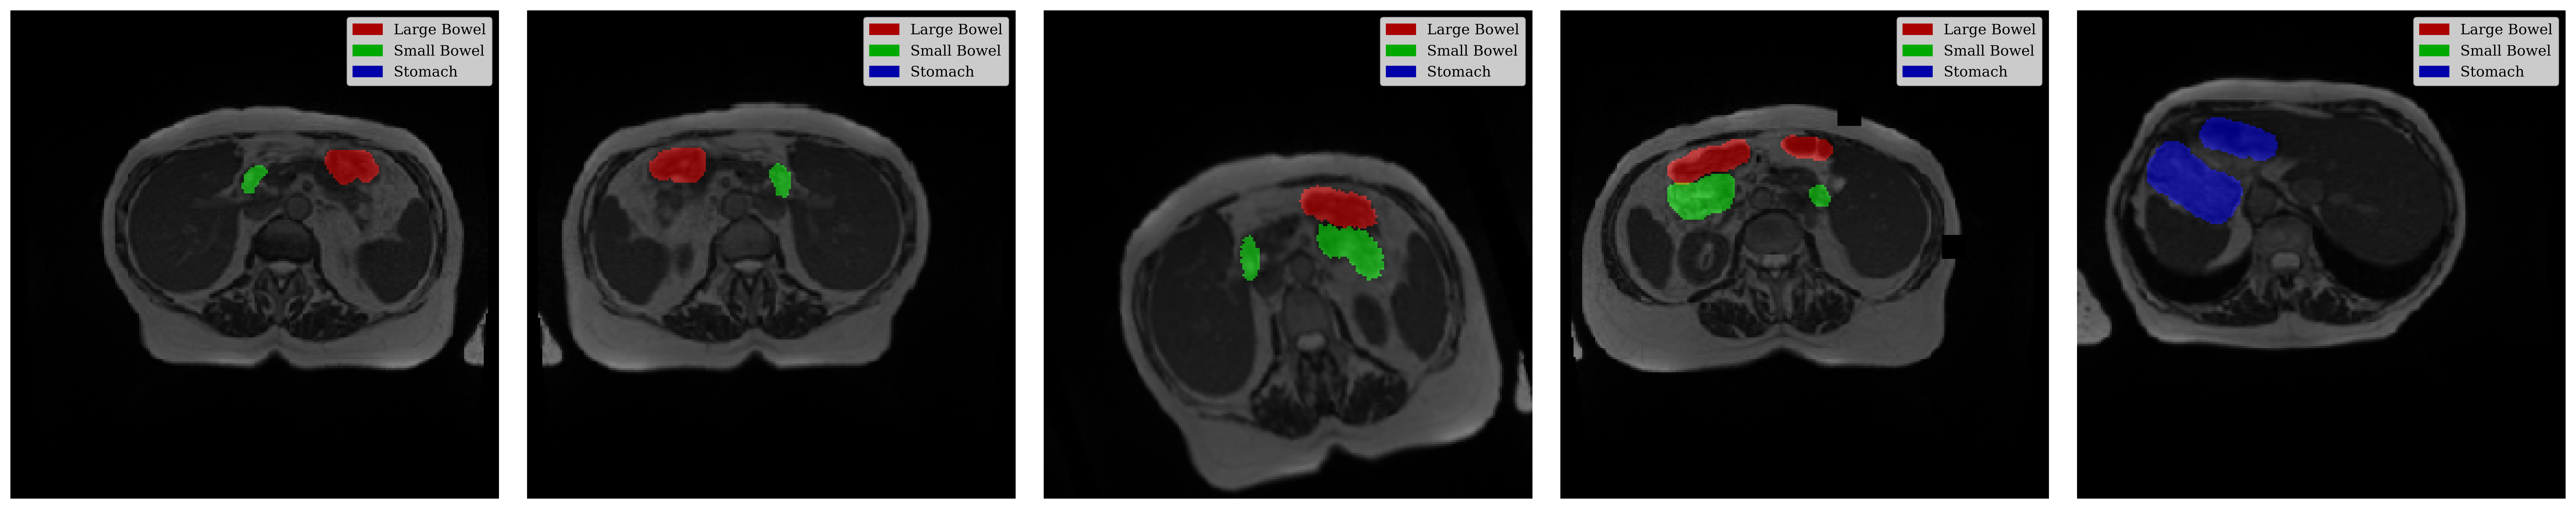

In [18]:
def plot_batch(imgs, msks, size=3):
    plt.rcParams['font.family']='serif'
    plt.figure(figsize=(5*size, 5),dpi=600)
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        show_img(img, msk)
    plt.tight_layout()
    plt.savefig('Example.jpg')
plot_batch(imgs,msks,size=5)
# count=0
# for imgs,msks in train_loader:
#     count=count+1
#     plot_batch(imgs,msks,5)
#     plt.savefig('Example'+str(count)+'.jpg')
#     if count>20:
#         break

In [19]:
import gc
gc.collect()

18198

In [20]:
!pip install pip install segmentation-models-pytorch

In [21]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import segmentation_models_pytorch as smp
import gc
from tqdm import tqdm


def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.T_max,
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0,
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr, )
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None

    return scheduler
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou


#loss function
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)



def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)


def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()

    dataset_size = 0
    running_loss = 0.0

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)

        batch_size = images.size(0)

        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss = criterion(y_pred, masks)
            loss = loss / CFG.n_accumulate

        scaler.scale(loss).backward()

        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(epoch=epoch,train_loss=f'{epoch_loss:0.4f}',
                         lr=f'{current_lr:0.5f}',
                         gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss


@torch.no_grad()
def valid_one_epoch(model, optimizer, dataloader, device, epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0.0

    val_scores = []

    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device, dtype=torch.float)

        batch_size = images.size(0)

        y_pred = model(images)
        loss = criterion(y_pred, masks)

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(epoch=epoch,valid_loss=f'{epoch_loss:0.4f}',
                         lr=f'{current_lr:0.5f}',
                         gpu_memory=f'{mem:0.2f} GB')
    val_scores = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, val_scores




In [31]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)


torch.cuda.empty_cache()
model = build_model()
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

In [36]:
def run_train_valid(model=model,optimizer=optimizer,scheduler=scheduler,train_loader=train_loader,valid_loader=valid_loader,n_epoch=100):
    best_dice      = -np.inf
    train_Loss_list=[]
    valid_loss_list=[]
    val_dice_list=[]
    val_jac_list=[]
    print('Start...')
    for i in range(n_epoch):
        train_loss=train_one_epoch(model, optimizer, scheduler, dataloader=train_loader, device=CFG.device, epoch=i)
        valid_loss,val_s=valid_one_epoch(model, optimizer, dataloader=valid_loader, device=CFG.device, epoch=i)
        val_dice, val_jaccard = val_s
        train_Loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        val_dice_list.append(val_dice)
        val_jac_list.append(val_jaccard)
        
        if val_dice >= best_dice:
            print(f"{c_}Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = i
            
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-U-Net.pt"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            
            print("Model Saved...")
    print('Success..')
    print(f"Bset Epoch:{i}  Best Dice Score:{best_dice:0.4f}   Best Jaccard Score:{best_jaccard:0.4f}")
    return train_Loss_list,valid_loss_list,val_dice_list,val_jac_list



In [37]:
l1,l2,l3,l4=run_train_valid()

Start...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.24it/s, epoch=0, gpu_memory=2.66 GB, lr=0.00200, valid_loss=0.8865]


Valid Score Improved (-inf ---> 0.0228)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.07it/s, epoch=1, gpu_memory=2.72 GB, lr=0.00200, valid_loss=0.8863]


Valid Score Improved (0.0228 ---> 0.0229)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, epoch=3, gpu_memory=2.70 GB, lr=0.00200, valid_loss=0.8862]


Valid Score Improved (0.0229 ---> 0.0229)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, epoch=4, gpu_memory=2.69 GB, lr=0.00200, valid_loss=0.8862]


Valid Score Improved (0.0229 ---> 0.0229)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.14it/s, epoch=5, gpu_memory=2.71 GB, lr=0.00200, valid_loss=0.8862]


Valid Score Improved (0.0229 ---> 0.0229)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, epoch=6, gpu_memory=2.70 GB, lr=0.00200, valid_loss=0.8862]


Valid Score Improved (0.0229 ---> 0.0229)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, epoch=7, gpu_memory=2.75 GB, lr=0.00200, valid_loss=0.8861]


Valid Score Improved (0.0229 ---> 0.0229)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, epoch=8, gpu_memory=2.70 GB, lr=0.00200, valid_loss=0.8860]


Valid Score Improved (0.0229 ---> 0.0230)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.21it/s, epoch=9, gpu_memory=2.75 GB, lr=0.00200, valid_loss=0.8859]


Valid Score Improved (0.0230 ---> 0.0230)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, epoch=10, gpu_memory=2.71 GB, lr=0.00200, valid_loss=0.8860]


Valid Score Improved (0.0230 ---> 0.0231)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.13it/s, epoch=11, gpu_memory=2.73 GB, lr=0.00200, valid_loss=0.8861]


Valid Score Improved (0.0231 ---> 0.0231)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, epoch=12, gpu_memory=2.69 GB, lr=0.00200, valid_loss=0.8860]


Valid Score Improved (0.0231 ---> 0.0231)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, epoch=13, gpu_memory=2.74 GB, lr=0.00200, valid_loss=0.8860]


Valid Score Improved (0.0231 ---> 0.0231)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.34it/s, epoch=14, gpu_memory=2.70 GB, lr=0.00200, valid_loss=0.8860]


Valid Score Improved (0.0231 ---> 0.0231)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.30it/s, epoch=15, gpu_memory=2.72 GB, lr=0.00200, valid_loss=0.8860]


Valid Score Improved (0.0231 ---> 0.0232)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.27it/s, epoch=16, gpu_memory=2.71 GB, lr=0.00200, valid_loss=0.8860]


Valid Score Improved (0.0232 ---> 0.0232)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.13it/s, epoch=17, gpu_memory=2.75 GB, lr=0.00200, valid_loss=0.8860]


Valid Score Improved (0.0232 ---> 0.0232)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.19it/s, epoch=20, gpu_memory=2.71 GB, lr=0.00200, valid_loss=0.8858]


Valid Score Improved (0.0232 ---> 0.0232)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  2.73it/s, epoch=21, gpu_memory=2.75 GB, lr=0.00200, valid_loss=0.8856]


Valid Score Improved (0.0232 ---> 0.0232)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, epoch=22, gpu_memory=2.71 GB, lr=0.00200, valid_loss=0.8856]


Valid Score Improved (0.0232 ---> 0.0232)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.17it/s, epoch=27, gpu_memory=2.72 GB, lr=0.00200, valid_loss=0.8858]


Valid Score Improved (0.0232 ---> 0.0233)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  2.75it/s, epoch=28, gpu_memory=2.70 GB, lr=0.00200, valid_loss=0.8857]


Valid Score Improved (0.0233 ---> 0.0233)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.26it/s, epoch=31, gpu_memory=2.74 GB, lr=0.00200, valid_loss=0.8853]


Valid Score Improved (0.0233 ---> 0.0233)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.28it/s, epoch=32, gpu_memory=2.72 GB, lr=0.00200, valid_loss=0.8853]


Valid Score Improved (0.0233 ---> 0.0233)
Model Saved...


Valid : 100%|██████████| 2/2 [00:00<00:00,  3.31it/s, epoch=99, gpu_memory=2.71 GB, lr=0.00200, valid_loss=0.8815]


Success..
Bset Epoch:99  Best Dice Score:0.0233   Best Jaccard Score:0.0119


In [38]:
def plot_process(list1,y_label,f_name):
    plt.figure(dpi=400)
    plt.plot(range(len(list1)),list1)
    plt.ylabel(y_label)
    plt.xlabel('Epoch')
    plt.savefig(f_name+'.jpg')
    plt.show()


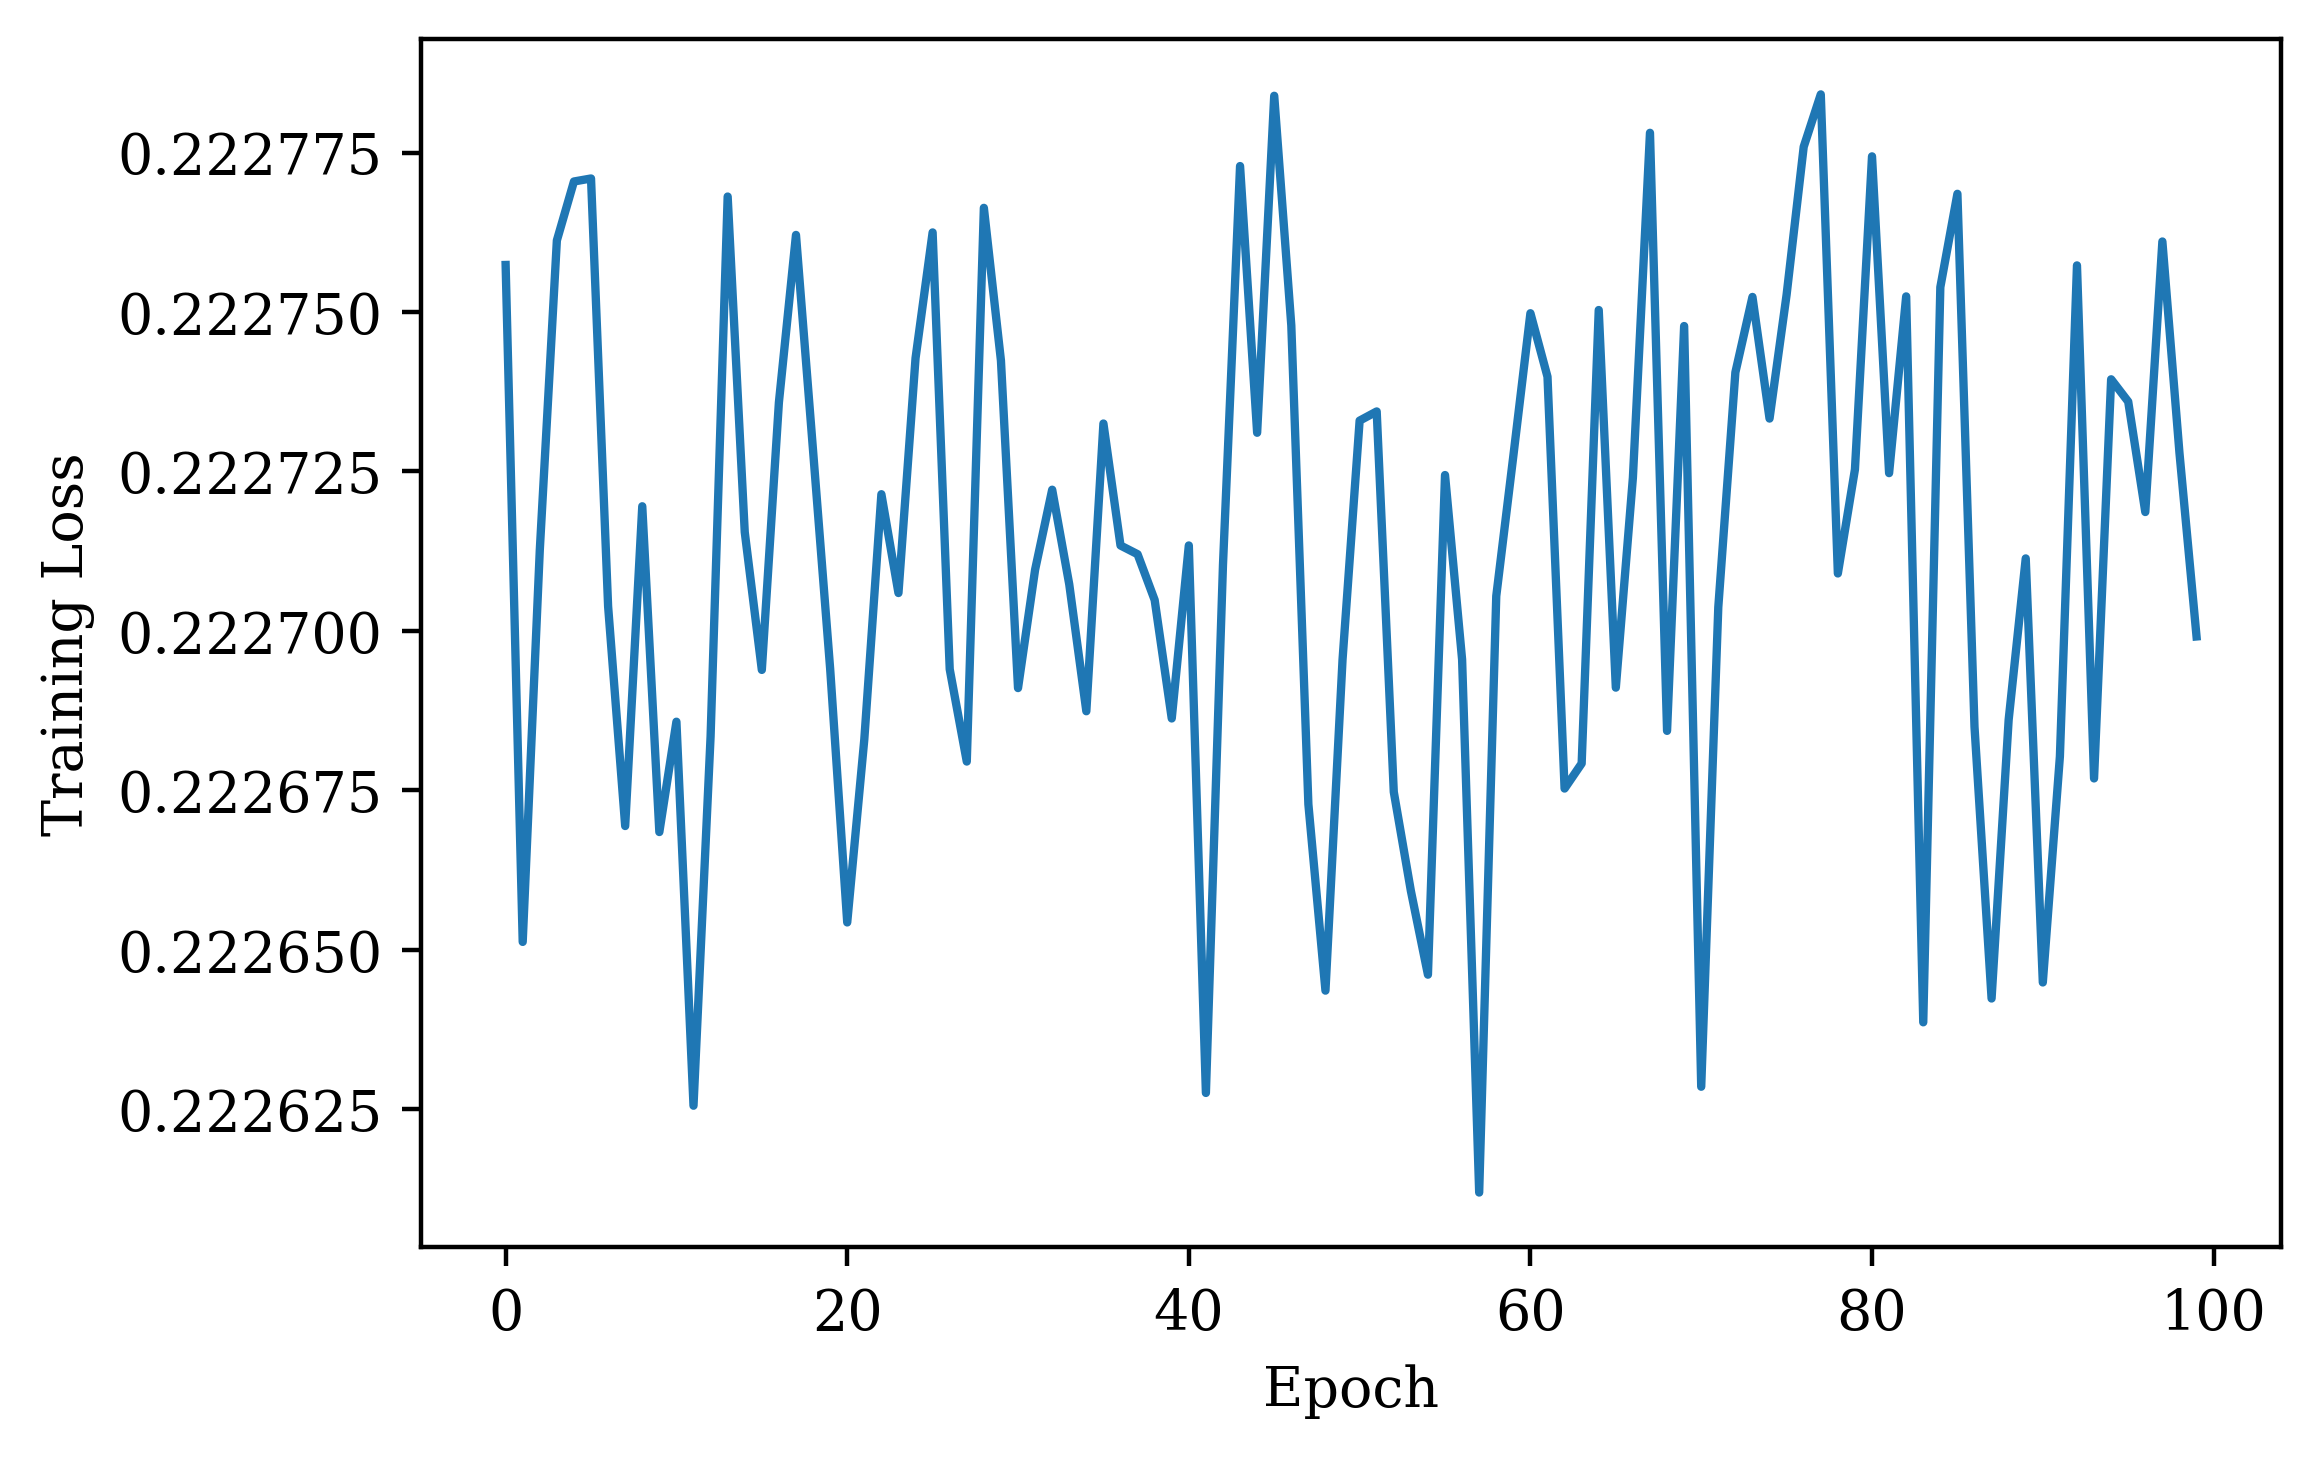

In [39]:
plot_process(l1,'Training Loss','train')

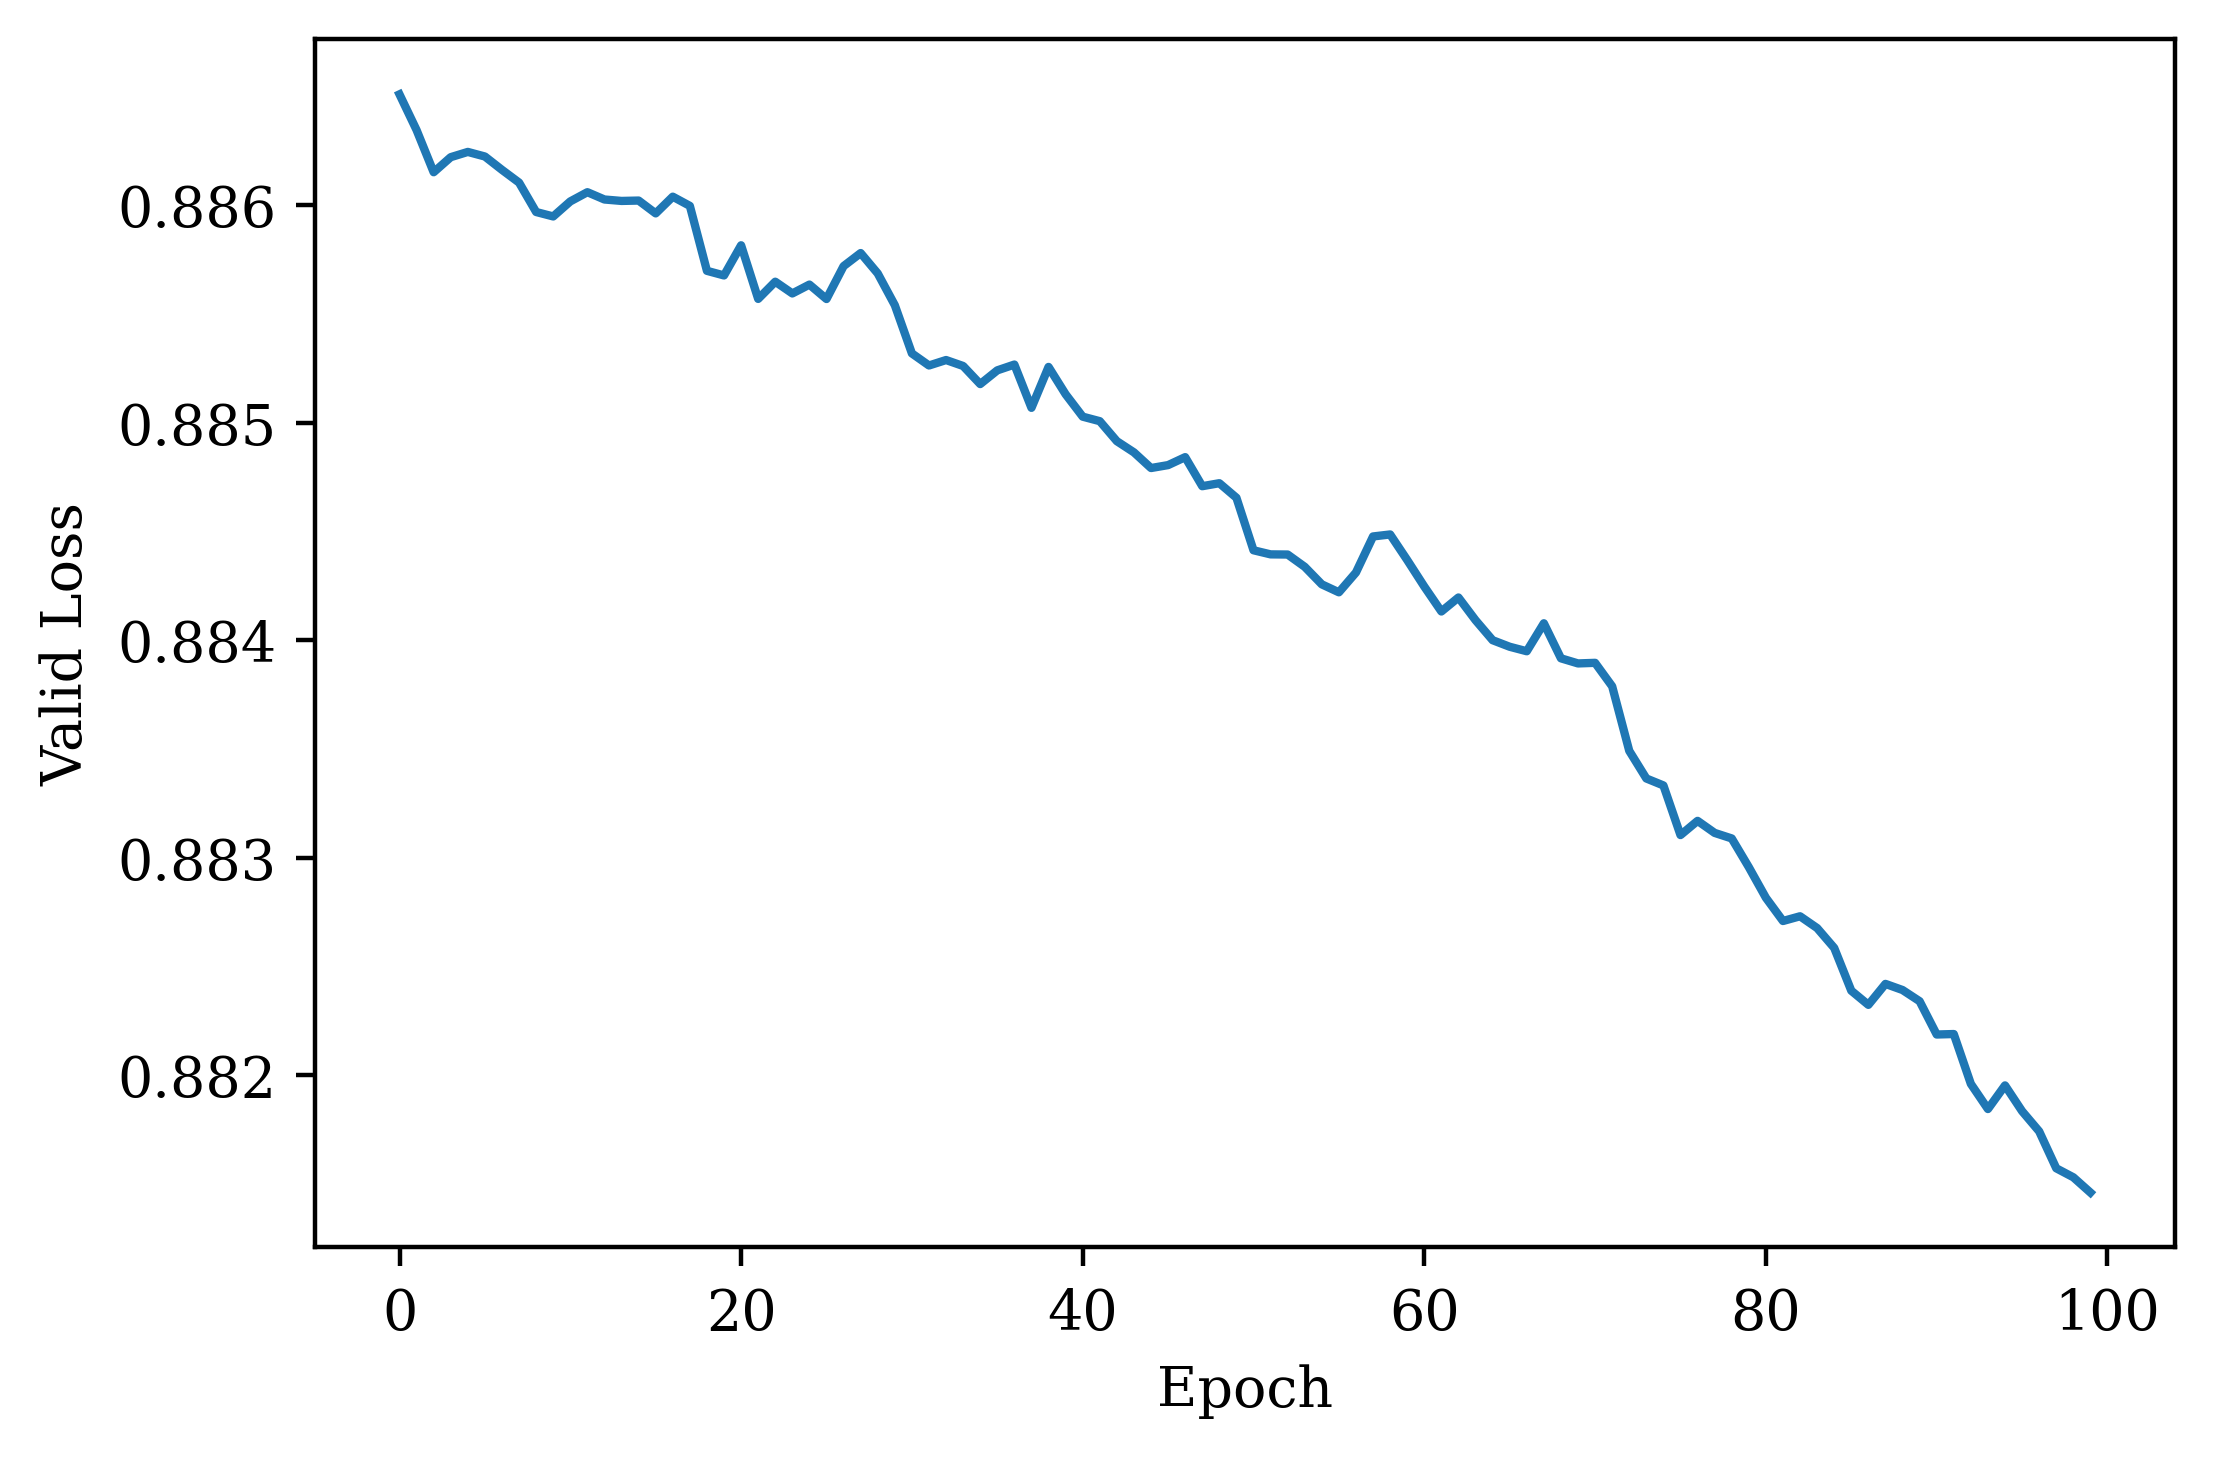

In [40]:
plot_process(l2,'Valid Loss','valid')

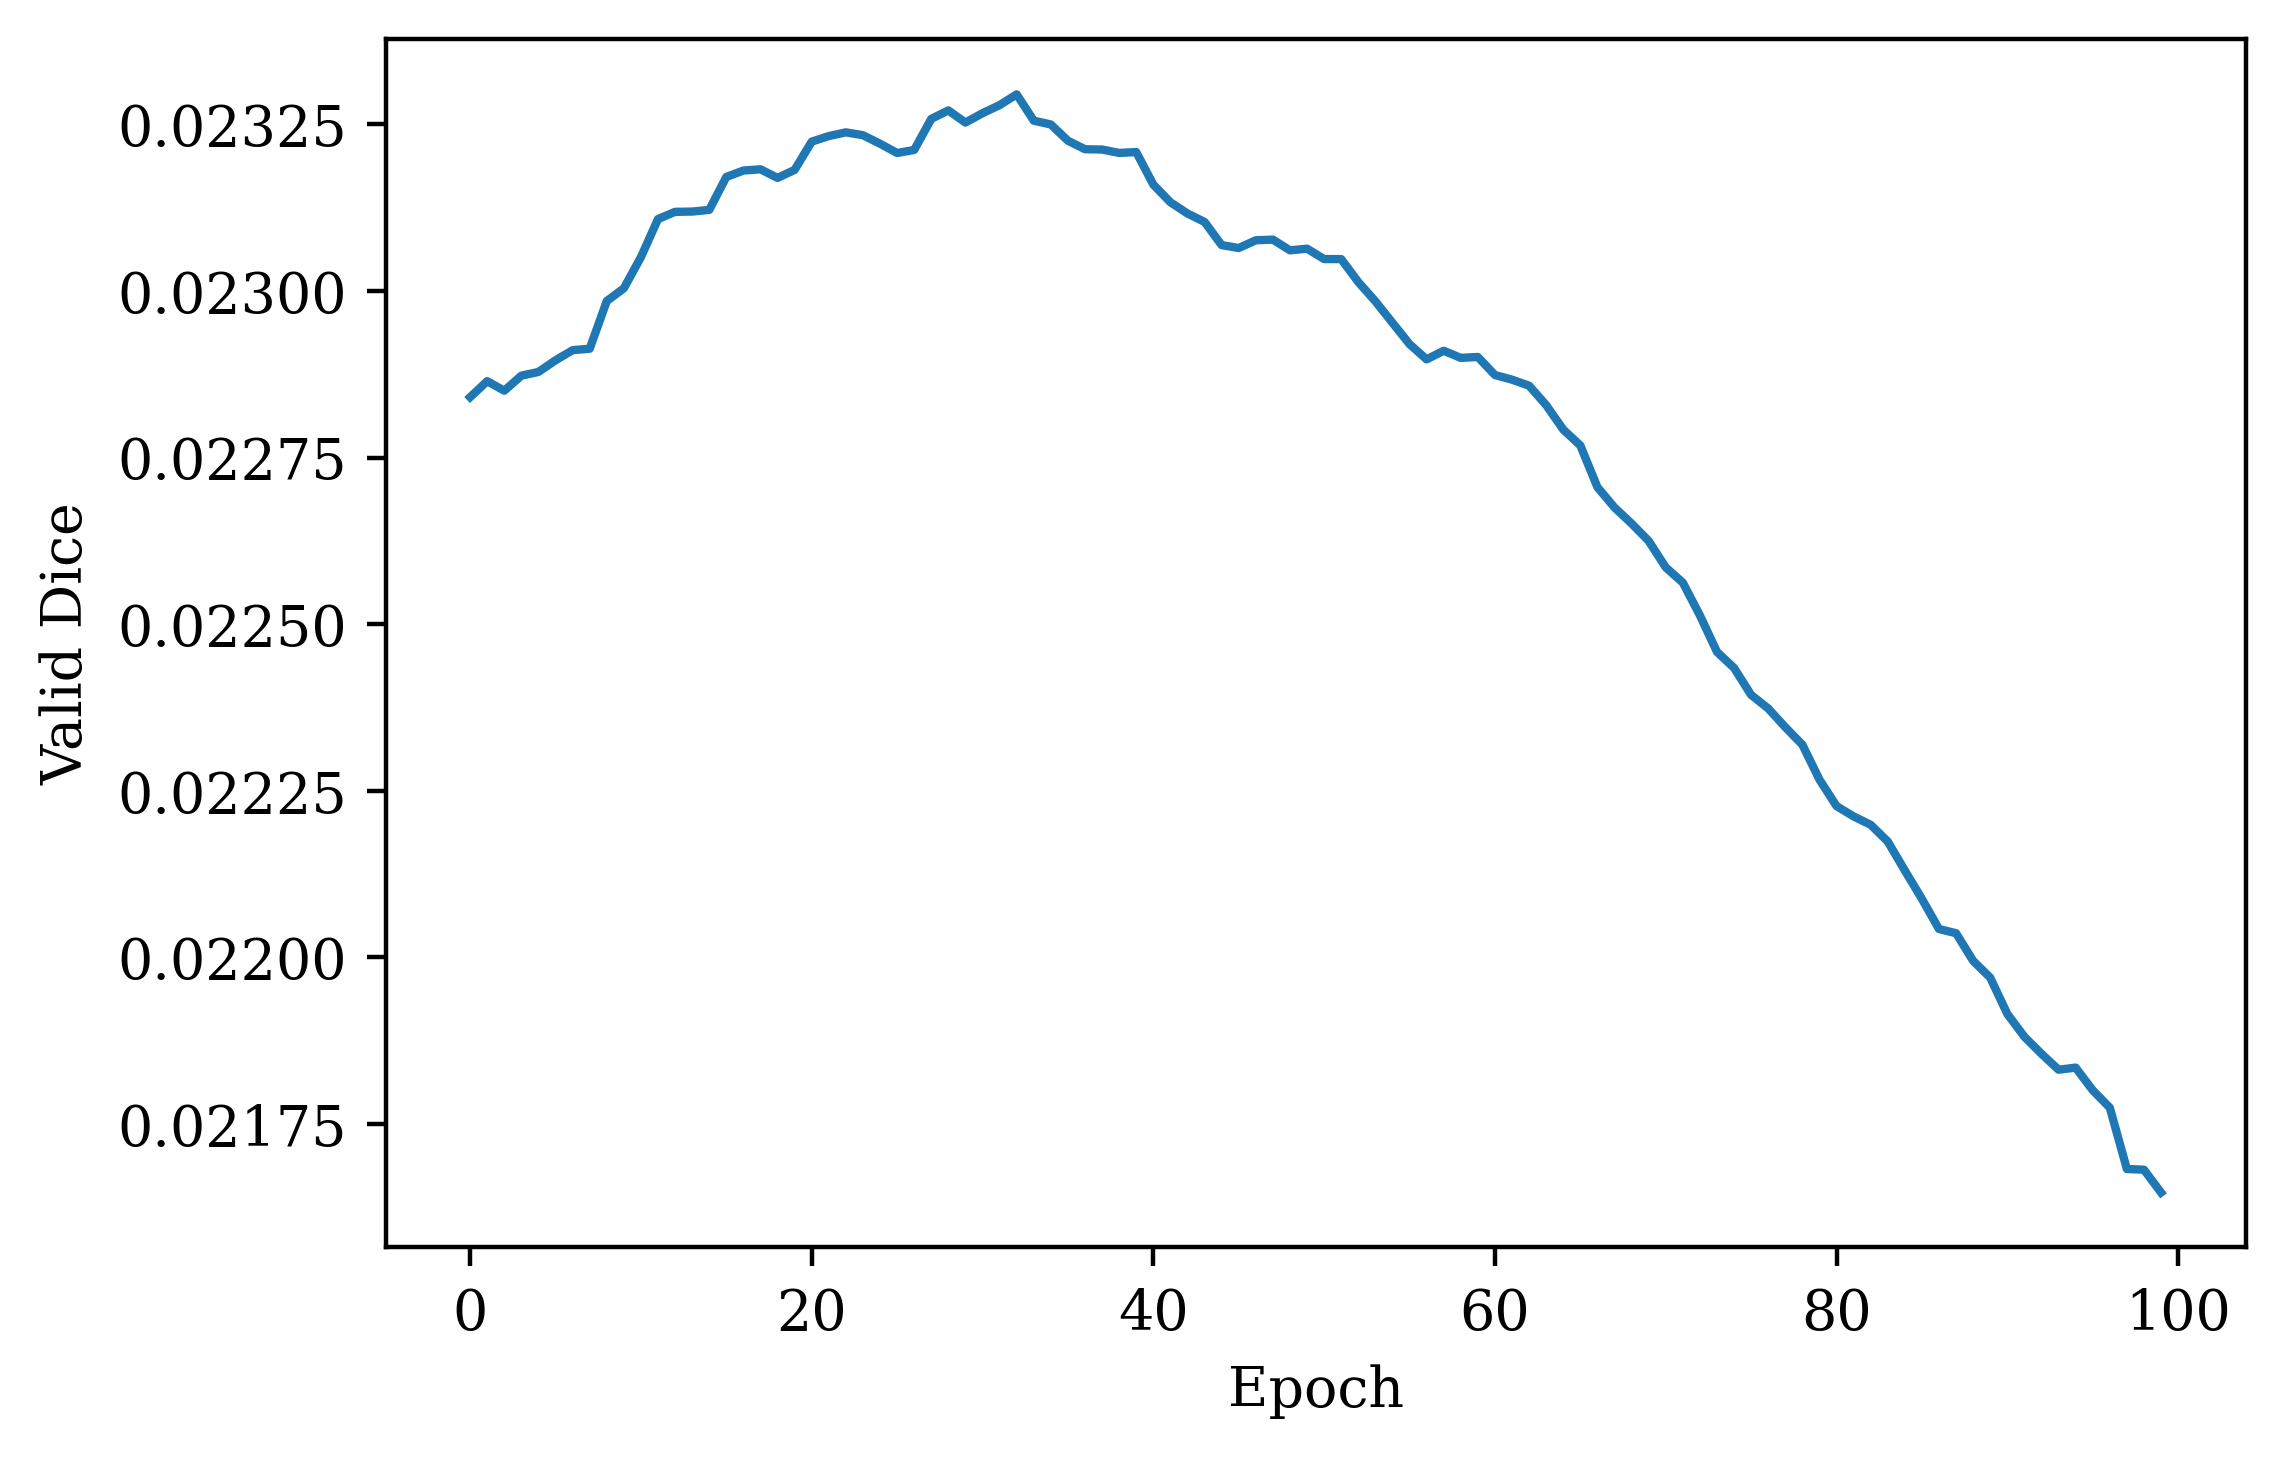

In [41]:
plot_process(l3,'Valid Dice','valid_d')

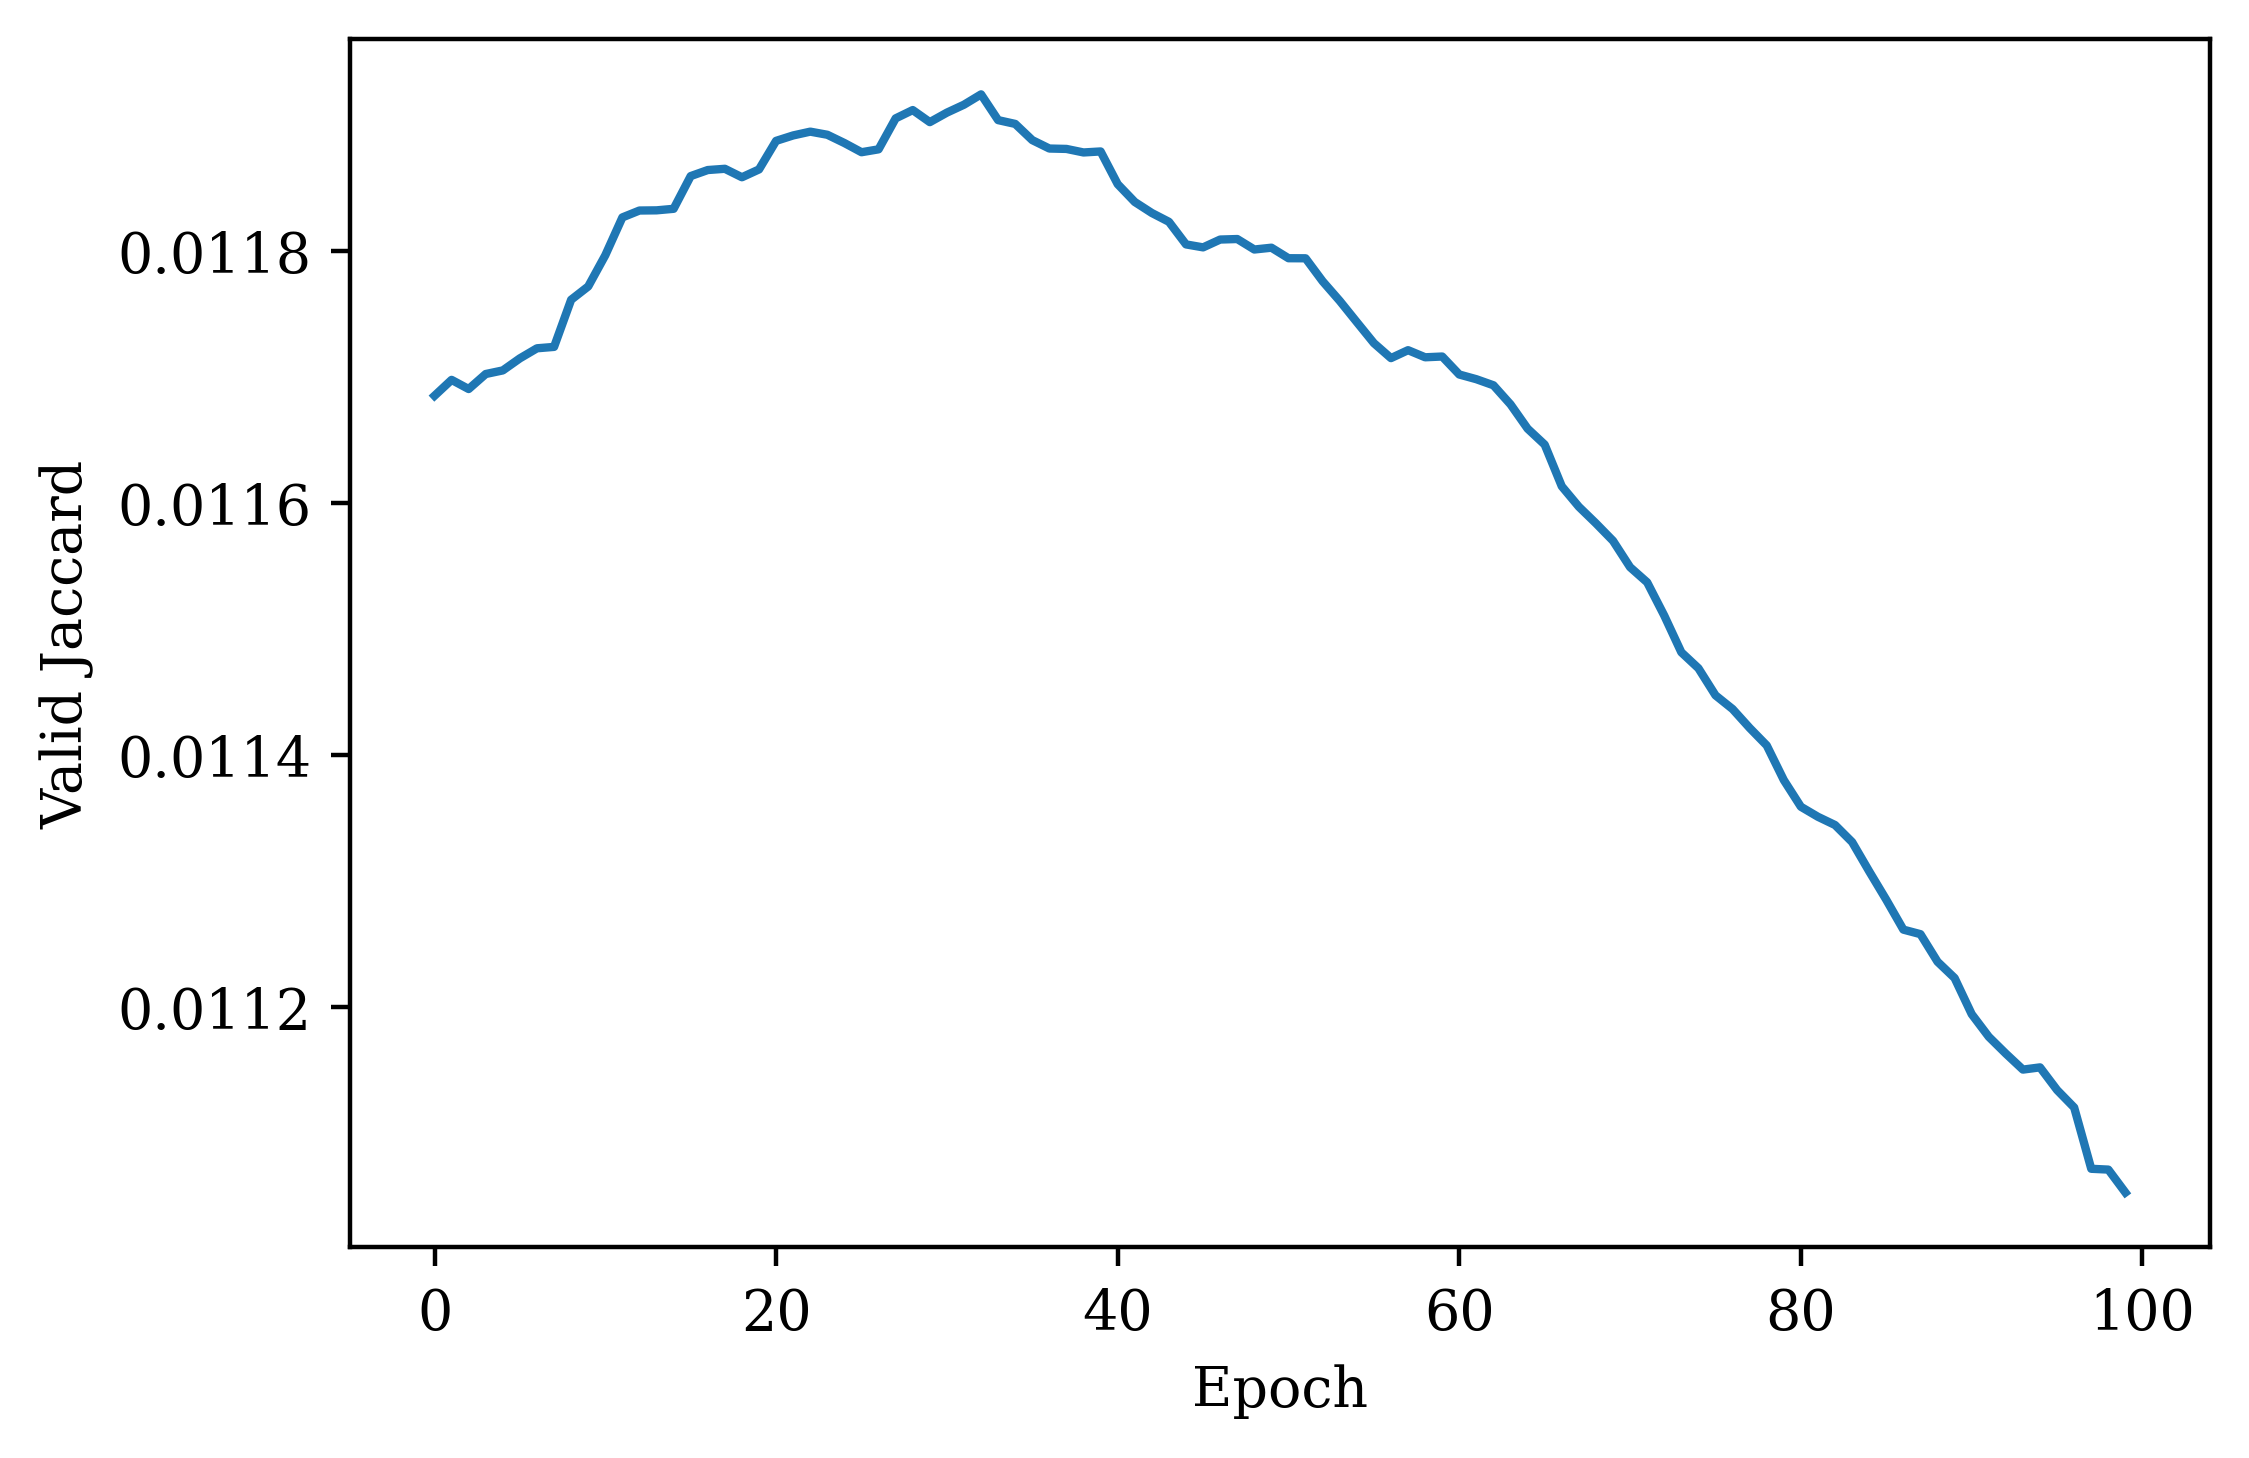

In [42]:
plot_process(l4,'Valid Jaccard','valid_j')